# Dog Breed Identification - Kaggle competition

## Init

* Load the training set.
* View a couple of images.
* Create a one layer model.
* Get a place on the leaderboard.

In [ ]:
import os
import random
import fnmatch
from shutil import copyfile, rmtree
import csv

import pandas
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

### Prepare training set

In [2]:
labels = pandas.read_csv('data/labels.csv')

In [3]:
labels.describe()

,id,breed
count,10222,10222
unique,10222,120
top,1383bc8b2db4943fafe13b7f289f4a03,scottish_deerhound
freq,1,126


Thinking a 90/10 training/dev split = 900 in the dev set.

Time to get it into a format that Keras likes.

In [5]:
rmtree(f'./data/prepared')

for label in labels.breed.unique():
    os.makedirs(f'./data/prepared/train/{label}', exist_ok=True)
    os.makedirs(f'./data/prepared/dev/{label}', exist_ok=True)
    os.makedirs(f'./data/prepared/sample/{label}', exist_ok=True)

for _, item_id, label in labels.itertuples():
    is_sample = random.random() > 0.8
    is_dev = random.random() > 0.9
    
    which_set = 'dev' if is_dev else 'train'
    copyfile(
        f'./data/train/{item_id}.jpg',
        f'./data/prepared/{which_set}/{label}/{item_id}.jpg')
    
    if is_sample:
        copyfile(
        f'./data/train/{item_id}.jpg',
        f'./data/prepared/sample/{label}/{item_id}.jpg')

In [6]:
_gen = ImageDataGenerator().flow_from_directory('./data/prepared/train', batch_size=4, class_mode='sparse')
x_batch, y_batch = next(_gen)

Found 9179 images belonging to 120 classes.


In [7]:
def to_plot(img):
    return np.rollaxis(img, 0, 1).astype(np.uint8)


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    """Taken from Fast.ai utils."""
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [8]:
label_to_id = {id: label for label, id in _gen.class_indices.items()}

In [79]:
titles = [label_to_id[i] for i in y_batch]

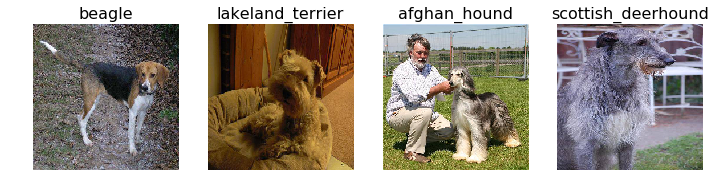

In [9]:
plots(x_batch, titles=titles)

### Create baseline model

In [10]:
print("Image size:", x_batch.shape)

Image size: (4, 256, 256, 3)


In [93]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model

inputs = Input(shape=(256, 256, 3))
x = Flatten()(inputs)
x = Dense(1024, activation='relu')(x)
outputs = Dense(_gen.num_class, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [94]:
gen = ImageDataGenerator()
train_gen = gen.flow_from_directory('./data/prepared/train')
dev_gen = gen.flow_from_directory('./data/prepared/dev')

Found 9179 images belonging to 120 classes.
Found 1043 images belonging to 120 classes.


In [95]:
steps_per_epoch = int(train_gen.samples / train_gen.batch_size)
val_steps = int(dev_gen.samples / dev_gen.batch_size)

In [115]:
model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, validation_data=dev_gen, validation_steps=val_steps)

Epoch 1/1
286/286 [==============================] - 1511s - loss: 16.0054 - acc: 0.0070 - val_loss: 16.0237 - val_acc: 0.0059


In [116]:
test_gen = gen.flow_from_directory('./data/test', batch_size=1, class_mode=None)

Found 10357 images belonging to 1 classes.


In [ ]:
model.evaluate_generator(dev_gen, steps=100)

In [101]:
def generate_submission(predictions, gen, output_file='sub.csv'):  
    fh = open(output_file, 'w')
    writer = csv.writer(fh)
    writer.writerow(['id'] + sorted(label_to_id.items(), key=lambda x: x[0]))
    for filename, prediction in zip(test_gen.filenames, predictions):
        dog_id = filename.split('/')[-1].split('.')[0]
        writer.writerow([dog_id] + list(prediction))
    fh.close()

In [102]:
generate_submission(predictions, test_gen)

In [113]:
x = next(test_gen)

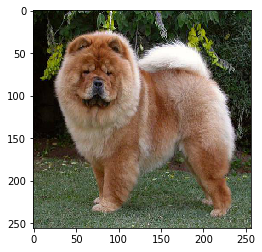

In [114]:
plt.imshow(to_plot(x[0]))

In [124]:
predictions

[16.118095397949219, 0.0]